In [ ]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import distributions as D

Parameter Settings
-------------------


In [ ]:
num_epochs = 50
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [ ]:
class VAE(nn.Module):
  def __init__(self, device):
    super(VAE, self).__init__()

    self.device = device
    self.c = 16
    self.z_dims = 16

    # Layers for q(z|x):
    self.qz_fc1 = nn.Linear(in_features=28*28, out_features=512)
    self.qz_fc2 = nn.Linear(in_features=512, out_features=256)
    self.qz_mu = nn.Linear(in_features=256, out_features=self.z_dims)
    self.qz_pre_sp = nn.Linear(in_features=256, out_features=self.z_dims)

    # Layers for p(x|z):
    self.px_l1 = nn.Linear(in_features=self.z_dims, out_features=256)
    self.px_fc1 = nn.Linear(in_features=256, out_features=512)
    self.px_fc2 = nn.Linear(in_features=512, out_features=28*28)

  def q_z(self, x):
    h = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
    h = F.relu(self.qz_fc1(h))
    h = F.relu(self.qz_fc2(h))
    z_mu = self.qz_mu(h)
    z_pre_sp = self.qz_pre_sp(h)
    z_std = F.softplus(z_pre_sp)
    return self.reparameterize(z_mu, z_std), z_mu, z_std

  def p_x(self, z):
    h = self.px_l1(z)
    h = F.relu(self.px_fc1(h))
    h = torch.sigmoid(self.px_fc2(h)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
    x = h.view(h.size(0), 1, 28, 28) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    return x

  def reparameterize(self, mu, std):
    eps = Variable(torch.randn(mu.size()))
    eps = eps.to(self.device)

    return mu + eps * std

  def sample_x(self, num=10):
    # sample latent vectors from the normal distribution
    z = torch.randn(num, self.z_dims)
    z = z.to(self.device)

    x_prob = self.p_x(z)

    return x_prob

  def reconstruction(self, x):
    z, _, _ = self.q_z(x)
    x_prob = self.p_x(z)

    return x_prob

  def forward(self, x):
    z, qz_mu, qz_std = self.q_z(x)

    x_prob = self.p_x(z)

    # For likelihood : <log p(x|z)>_q :
    elbo = torch.sum(torch.flatten(x.view(-1, 784) * torch.log(x_prob.view(-1, 784) + 1e-8)
                                    + (1 - x.view(-1, 784)) * torch.log(1 - x_prob.view(-1, 784) + 1e-8),
                                    start_dim=1),
                      dim=-1)
    
    qz = D.normal.Normal(qz_mu, qz_std)
    qz = D.independent.Independent(qz, 1)
    pz = D.normal.Normal(torch.zeros_like(z), torch.ones_like(z))
    pz = D.independent.Independent(pz, 1)
    # For : <log p(z)>_q
    elbo += pz.log_prob(z)

    # For : -<log q(z|x)>_q
    elbo -= qz.log_prob(z)

    return -elbo.mean()



In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
vae = VAE(device)
vae = vae.to(device)

cuda:0


In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        optimizer.zero_grad()
        
        image_batch = image_batch.to(device)

        loss = vae(image_batch)
        
        # backpropagation
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average negative ELBO: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average negative ELBO: 161.285216
Epoch [2 / 50] average negative ELBO: 123.885484
Epoch [3 / 50] average negative ELBO: 117.037572
Epoch [4 / 50] average negative ELBO: 113.343102
Epoch [5 / 50] average negative ELBO: 111.069345
Epoch [6 / 50] average negative ELBO: 109.398349
Epoch [7 / 50] average negative ELBO: 108.062655
Epoch [8 / 50] average negative ELBO: 107.123102
Epoch [9 / 50] average negative ELBO: 106.438908
Epoch [10 / 50] average negative ELBO: 105.851704
Epoch [11 / 50] average negative ELBO: 105.375518
Epoch [12 / 50] average negative ELBO: 104.944509
Epoch [13 / 50] average negative ELBO: 104.595042
Epoch [14 / 50] average negative ELBO: 104.224661
Epoch [15 / 50] average negative ELBO: 103.991014
Epoch [16 / 50] average negative ELBO: 103.690628
Epoch [17 / 50] average negative ELBO: 103.378226
Epoch [18 / 50] average negative ELBO: 103.209067
Epoch [19 / 50] average negative ELBO: 102.968227
Epoch [20 / 50] average negative ELBO: 102.836

In [ ]:
# c=16, z=16: Epoch [100 / 100] average reconstruction error: 100.382538

In [ ]:
# this is how the VAE parameters can be saved:
# torch.save(hvae.state_dict(), './pretrained/hvae.pth')

Original images


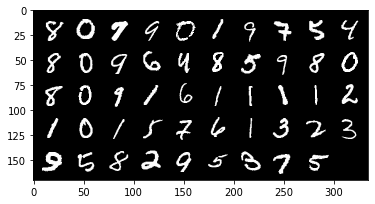

VAE reconstruction:


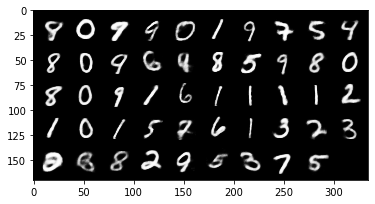

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = vae.reconstruction(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

In [ ]:
vae.eval()

with torch.no_grad():
    images = images.to(device)
    nElbo = vae(images)
    print(nElbo)


rand = torch.rand_like(images)

with torch.no_grad():
    rand = rand.to(device)
    nElbo = vae(rand)
    print(nElbo)

zeros = torch.zeros_like(images)

with torch.no_grad():
    zeros = zeros.to(device)
    nElbo = vae(zeros)
    print(nElbo)

ones = torch.ones_like(images)

with torch.no_grad():
    ones = ones.to(device)
    nElbo = vae(ones)
    print(nElbo)



tensor(102.7758, device='cuda:0')
tensor(2951.2690, device='cuda:0')
tensor(28.2617, device='cuda:0')
tensor(7257.7354, device='cuda:0')


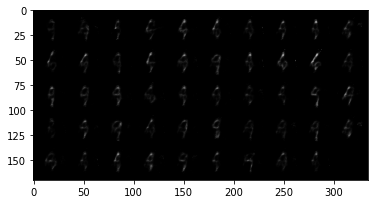

In [ ]:
with torch.no_grad():
  images = zeros.to(device)
  images = vae.reconstruction(images)
  images = images.cpu()
  images = to_img(images)
  np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
  plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
  plt.show()

In [ ]:
m = images.mean(dim=0).repeat((batch_size,1,1,1))
with torch.no_grad():
    m = m.to(device)
    nElbo = vae(m)
    print(nElbo)

tensor(259.5256, device='cuda:0')


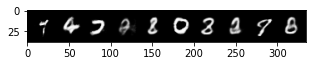

In [ ]:
vae.eval()

with torch.no_grad():

    # sample images
    img_samples = vae.sample_x()
    img_samples = img_samples.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_samples,10,5))
    plt.show()